In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import cv2
import os
import copy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import operator
from sklearn.cluster import KMeans

#red = 1, purple = 2, green =3
#empty 1 , speckled 2, filled 3

In [2]:
def check_colour(img, card_props):
    height, width, dim = img.shape

    ## convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    ## mask of green

    red_low = cv2.inRange(hsv, (0, 20, 50), (10, 255, 255))
    red_high = cv2.inRange(hsv, (170, 40, 50), (180, 255, 255))
    purple = cv2.inRange(hsv, (80, 20, 0), (180, 255, 255))
    green = cv2.inRange(hsv, (36, 20, 0), (80, 255, 255))
    mask =  [red_low, red_high, purple, green]

    max_percent_area = 0
    max_percent_area_index = 0
    
    for i in range(len(mask)):
        target = cv2.bitwise_and(img,img, mask=mask[i])

        area = target.any(axis=-1).sum()
        percent_area = ((area/(target.shape[0]*target.shape[1]))*100)/card_props['number']
        if percent_area > max_percent_area:
            max_percent_area_index  = i
            max_percent_area = percent_area

    if max_percent_area_index == 0:
        card_props['colour'] = 1
    elif max_percent_area_index == 1 :
        card_props['colour'] = 1
    elif max_percent_area_index == 2:
        card_props['colour'] = 2
    elif max_percent_area_index == 3:
        card_props['colour'] = 3
    #
    if max_percent_area > 5:
        card_props['fill'] = 3
    elif max_percent_area > 2.2:
        card_props['fill'] = 2
    elif max_percent_area > 0.5:
        card_props['fill'] = 1

    return card_props

In [3]:
def angle_cos(p0, p1, p2):
   d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
   return abs(np.dot(d1, d2) / np.sqrt(np.dot(d1, d1)*np.dot(d2, d2)))

In [4]:
def find_cards(img):
   img = cv2.GaussianBlur(img, (5, 5), 0)
   cards = []

   for gray in cv2.split(img):
       for thrs in range(0, 255, 25):
           if thrs == 0:
               edges = cv2.Canny(gray, 0, 50, apertureSize=5)
#                 cv2.imshow('edges' ,edges)
               bin = cv2.dilate(edges, None)
               
           else:
               retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
           bin, contours, hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
           for cnt in contours:
               
               leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
               rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
               topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
               bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])
               cnt_len = cv2.arcLength(cnt, True)
               cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
               if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                   cnt = cnt.reshape(-1, 2)
                   max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                   if max_cos < 0.4 and cv2.contourArea(cnt) < 1000000 and cv2.contourArea(cnt) > 100000:
                       cards.append(cv2.boundingRect(np.array([leftmost, rightmost, topmost, bottommost])))
                   
   return cards

In [14]:
def find_shapes(image):

    card_props = {'shape': 0, 'fill': 0, 'number': 0, 'colour': 0}
    
    blur_img = cv2.blur(image, (3, 3))
    gray_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2GRAY)
    thr_image = cv2.Canny(gray_img, 50, 220, apertureSize=3)
    thr_image = cv2.dilate(thr_image, np.ones((3, 3), np.uint8))
    cont_img, contours, hierarchy = cv2.findContours(thr_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        if cv2.contourArea(cnt) > 5000 and cv2.contourArea(cnt) < 200000:
            cv2.drawContours(draw_on, [cnt], 0, (0, 255, 0), 6)

            epsilon = 0.005*cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            
            if approx.shape[0] == 4:
                card_props['shape'] = 1
                card_props['number'] += 1 
            elif approx.shape[0] < 18:
                card_props['shape'] = 2
                card_props['number'] += 1 
            elif approx.shape[0] >= 19:
                card_props['shape'] = 3
                card_props['number'] += 1

    card_props_out = check_colour(image[:], card_props)
    return card_props_out

{'shape': 1, 'fill': 1, 'number': 2, 'colour': 1}


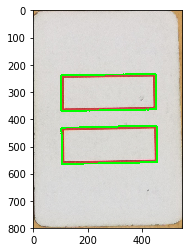

{'shape': 2, 'fill': 3, 'number': 2, 'colour': 3}


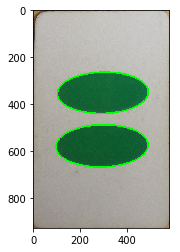

{'shape': 2, 'fill': 3, 'number': 2, 'colour': 2}


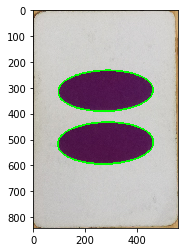

{'shape': 1, 'fill': 3, 'number': 3, 'colour': 2}


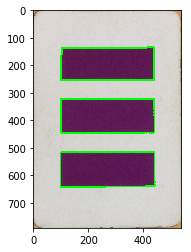

{'shape': 2, 'fill': 2, 'number': 3, 'colour': 2}


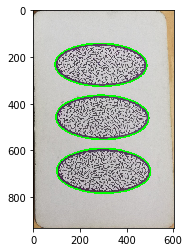

{'shape': 1, 'fill': 1, 'number': 2, 'colour': 3}


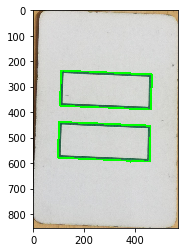

{'shape': 3, 'fill': 1, 'number': 2, 'colour': 1}


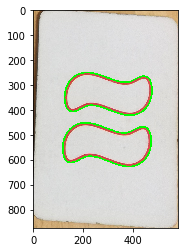

{'shape': 1, 'fill': 2, 'number': 1, 'colour': 3}


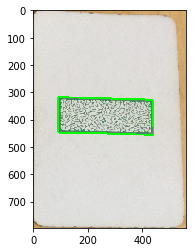

{'shape': 2, 'fill': 3, 'number': 3, 'colour': 3}


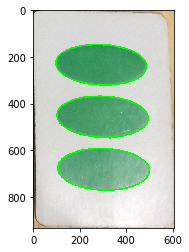

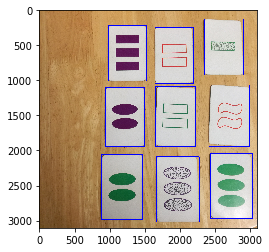

True

In [15]:
image_file = 'Set_Game_Computer_Vision/source_cards/set_game_board.jpg'

img = cv2.imread(image_file)
img_2 = copy.deepcopy(img)
cards = find_cards(img)
cards = cv2.groupRectangles(cards, 1)[0]

name_iterator = 0 
for card in cards:

    card_img = img[card[1]:card[1]+card[3], card[0]:card[0]+card[2]]
    
    cv2.imwrite('sliced_cards/slice_' + str(name_iterator) + '.png', card_img)
    
#     cv2.imshow('thiscard', card_img)

    draw_on = copy.deepcopy(card_img)

    # plt.imshow(cv2.cvtColor(card_img, cv2.COLOR_BGR2RGB))
    # plt.show()
    
    shapes = find_shapes(card_img)
    print(shapes)
    plt.imshow(cv2.cvtColor(draw_on, cv2.COLOR_BGR2RGB))
    plt.show()

    cv2.rectangle(img_2, (card[0], card[1]), (card[0]+card[2], card[1]+card[3]), (255, 0, 0), thickness=10)
    name_iterator += 1
    
# #     plt.imshow(img)
# ch = 0xFF & cv2.waitKey()
# if ch == 27:
#     exit()
    
# cv2.waitKey(0)
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('sliced_cards/output.jpg', img_2)
# cv2.destroyAllWindows()
# cv2.waitKey(1)
